<a href="https://colab.research.google.com/github/bedretdinov/ML_tools/blob/master/Time_Series_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Применение сверточной сети для классификации активности человека

Ссылка на полный датасет - https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip
Для данной работы будет использован предобработанный датасет, в котором сохранены три класса. Набор данных уже преобразован в 3-х мерный формат, необходимый для работы сети.

In [0]:
#Монтируем Гугл-диск (перейдите по сгенерированной ссылке чтобы получить код активации и скопируйте его в форму)
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

In [0]:
# Загружаем данные
# Данные содержат 2-х секундные показания (частота семплирования 52 Гц) акселерометра закрепленного на груди у человека.
# 1, 2 и 3 признаки - это составляющие вектора ускорения вдоль осей x, y, z соответсвенно.
# Датасет содержит измерения для 15 разных людей
data = np.load('/content/gdrive/My Drive/Accelerometer_ext.npz')
X = data['a'][:,:,:3]
label = data['a'][:,-1,3]

In [0]:
X.shape

(6435, 104, 3)

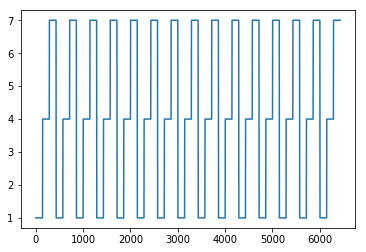

In [0]:
plt.plot(label)

In [0]:
label.shape

(6435,)

In [0]:
# Разбиение на тестовую и обучающую выборки (random_state фиксирован для повторяемости результатов)
X_train, X_test, y_train, y_test = train_test_split(X, label, test_size=0.2, random_state=999)

In [0]:
# One-Hot Encoding
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train = enc.fit_transform(y_train.reshape(-1, 1))
y_test = enc.transform(y_test.reshape(-1, 1))

In [0]:
# Перекодируем категории в названия действий
categories = ['Working at Computer', 'Walking', 'Talking while Standing']
enc.categories_ = categories

In [0]:
# Полезные константы
lenght = X_train.shape[1]
num_features = X_train.shape[2]
num_classes = len(enc.categories_)
nb_epochs = 50
batch_size=256

In [0]:
# Создаем сеть
x = layers.Input((lenght, num_features))

x1 = layers.BatchNormalization()(x)
x1 = layers.SpatialDropout1D(0.1)(x1)
conv1 = layers.Conv1D(32, 8, 2, padding='same')(x1)
conv1 = layers.BatchNormalization()(conv1)
conv1 = layers.Activation('relu')(conv1)
    
conv2 = layers.Conv1D(64, 5, 2, padding='same')(conv1)
conv2 = layers.BatchNormalization()(conv2)
conv2 = layers.Activation('relu')(conv2)
    
conv3 = layers.Conv1D(32, 3, 2, padding='same')(conv2)
conv3 = layers.BatchNormalization()(conv3)
conv3 = layers.Activation('relu')(conv3)
    
full = layers.GlobalAveragePooling1D()(conv3)    
out = layers.Dense(num_classes, activation='softmax')(full)
    
    
model = Model(inputs=x, outputs=out)
     
optimizer = optimizers.Adam(lr=0.0005)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 104, 3)            0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 104, 3)            12        
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 104, 3)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 52, 32)            800       
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 52, 32)            128       
_________________________________________________________________
activation (Activation)      (None, 52, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 64)            10304     
__________

In [0]:
# Обучаем. Данные шумные, так что метрика на валидации не сразу начнет улучшаться
hist = model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epochs, verbose=1, validation_data=(X_test, y_test))

Train on 5148 samples, validate on 1287 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
5148/5148 [==============================] - 2s 452us/sample - loss: 0.8331 - acc: 0.6142 - val_loss: 11.0460 - val_acc: 0.3147
Epoch 2/50
5148/5148 [==============================] - 1s 234us/sample - loss: 0.6025 - acc: 0.7706 - val_loss: 11.0460 - val_acc: 0.3147
Epoch 3/50
5148/5148 [==============================] - 1s 237us/sample - loss: 0.5389 - acc: 0.7949 - val_loss: 10.8059 - val_acc: 0.3147
Epoch 4/50
5148/5148 [==============================] - 1s 239us/sample - loss: 0.5231 - acc: 0.7993 - val_loss: 9.8766 - val_acc: 0.3147
Epoch 5/50
5148/5148 [==============================] - 1s 239us/sample - loss: 0.4878 - acc: 0.8114 - val_loss: 8.5604 - val_acc: 0.3147
Epoch 6/50
5148/5148 [==============================] - 1s 238us/sample - loss: 0.4778 - acc: 0.8141 - val_loss: 7.7962 - val_acc: 0.3147
Epoch 7/50
5148/5148 [==============================] - 1s 239us/sample -

# Домашнее задание


**Задание Light**

Оптимизировать предложенную в шаблоне архитектуру сети изменяя:
1) Количество фильтров в сверточных слоях
2) Добавляя дропаут после сверточных слоев и подбирая его процент
3) Активации нейронов
4) Оптимизатор и его параметры
5) Stride в свертках
Опционально: Реализовать MLP или ResNet архитектуру из лекции для решения этой задачи.

**Задание Pro**
На выбор:
- Преобразовать одномерный ряд в изображение одним из методов, описанном в лекции и решить задачу классификации при помощи двумерной светрочной сети (LeNet);
- Датасет отсортирован, то есть данные от разных людей не перемешаны, а идут друг за другом.
Можно разделить набор данных на 15 равных частей по 429 наблюдений в каждом. И разметить их от 1 до 15. По этим новым данным построить модель, которая будет классифицировать не виды активности, а людей.
- Создать модель на произвольных данных. Данные можно взять с Kaggle (https://www.kaggle.com/datasets?sortBy=hottest&group=public&page=1&pageSize=20&size=all&filetype=all&license=all&tagids=6618) (фильтровать по тэгу Time Series) или в репозитории UCI (https://archive.ics.uci.edu/ml/datasets.php) (в меню слева выбрать Time Series)